In [1]:
!apt-get update && apt-get install -y git
!pip install git+https://github.com/facebookresearch/segment-anything.git  opencv-python pycocotools  onnxruntime onnx

Hit:1 http://deb.debian.org/debian bullseye InRelease
Get:2 http://developer.download.nvidia.com/compute/cuda/repos/debian11/x86_64  InRelease [1581 B]
Get:3 http://deb.debian.org/debian-security bullseye-security InRelease [27.2 kB]
Get:4 http://deb.debian.org/debian bullseye-updates InRelease [44.1 kB]
Get:5 http://deb.debian.org/debian-security bullseye-security/main amd64 Packages [296 kB]
Fetched 368 kB in 2s (182 kB/s)   
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  git-man less libcbor0 libcurl3-gnutls liberror-perl libfido2-1
  libgdbm-compat4 libnghttp2-14 libperl5.32 libpsl5 librtmp1 libssh2-1
  libxmuu1 openssh-client patch perl perl-modules-5.32 publicsuffix xauth
Suggested packages:
  gettext-base git-daemon-run | git-daemon-sysvinit git-doc git-el git-email
  git-gui gitk gitweb git-cvs git-mediawiki git-svn keychain libpam-ssh
  monkeys

# Automatically generating object masks with SAM

Since SAM can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image. This method was used to generate the dataset SA-1B. 

The class `SamAutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

In [2]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [2]:
using_colab = False

In [3]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
    
    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
        
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

## Set-up

In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [5]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    # print(img)
    ax.imshow(img)
    img[:,:, :3] *= 255
    # im = Image.fromarray(img, 'RGBA')
    # return im

## Example image

In [13]:
import os
from PIL import Image

ROOT_PATH = '/workspace/NN'
DATA_PATCH = os.path.join(ROOT_PATH, 'data')

files = [i for i in [ os.path.join(DATA_PATCH, 'sirius_data', f'{i}.jpg') for i in range(17)] if os.path.isfile(i)]
images =  [cv2.imread(i) for i in files]
images = [cv2.cvtColor(i, cv2.COLOR_BGR2RGB) for i in images]
images[0]

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

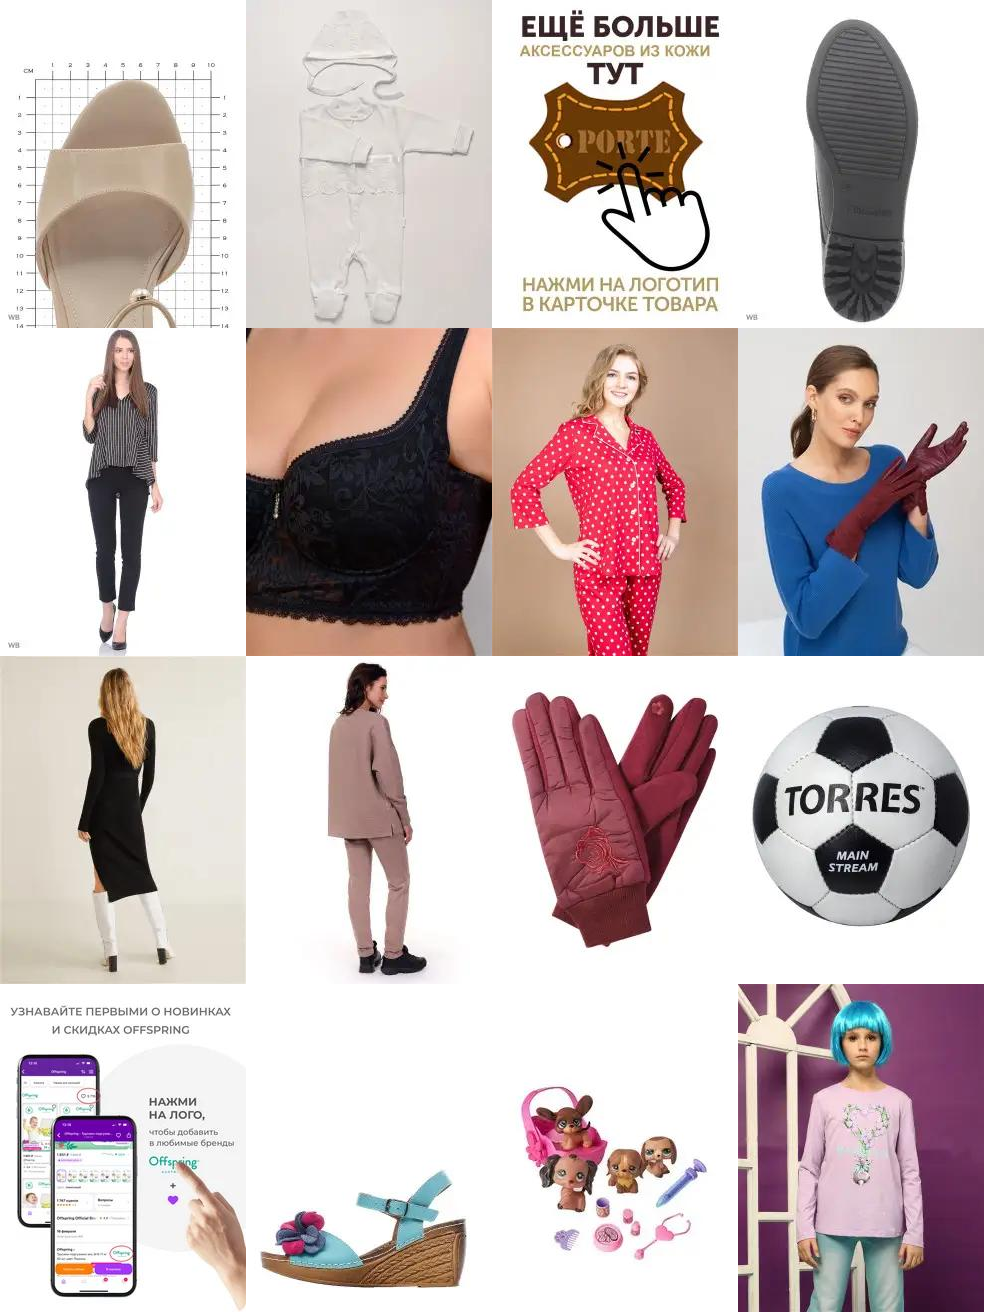

In [14]:
new_im = Image.new('RGBA', (246 * 4, 328* 4))

#Here I resize my opened image, so it is no bigger than 100,100
#
#Iterate through a 4 by 4 grid with 100 spacing, to place my image
for i in range(0, 4,1):
    for j in range(0, 4,1):
        #I change brightness of the images, just to emphasise they are unique copies.
        # im=Image.eval(im,lambda x: x+(i+j)/30)
        #paste the image at location i,j:
        im = Image.fromarray(images[i * 4 + j], 'RGB')
        # im = 
        im.thumbnail((246,328))
        new_im.paste(im, (i*246,j * 328))

new_im.show()

## Automatic mask generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [15]:
import os
import cv2



pretrained_ckpt = '/workspace/NN/weights/sam/sam_vit_h_4b8939.pth'

import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = pretrained_ckpt
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

To generate masks, just run `generate` on an image.

In [16]:
masks = [mask_generator.generate(i) for i in images]

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

In [17]:
print(len(masks[0]))
print(masks[0][0].keys())
print(*[ _i for i in masks[0] if (_i := dict(i)) is None or "segmentation" not in _i or  _i.pop("segmentation") is not None], sep='\n\n')

38
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])
{'area': 29964, 'bbox': [37, 80, 155, 247], 'predicted_iou': 1.009846568107605, 'point_coords': [[188.34375, 230.625]], 'stability_score': 0.9502307176589966, 'crop_box': [0, 0, 246, 328]}

{'area': 48807, 'bbox': [1, 0, 243, 327], 'predicted_iou': 1.0008455514907837, 'point_coords': [[19.21875, 87.125]], 'stability_score': 0.987083375453949, 'crop_box': [0, 0, 246, 328]}

{'area': 5712, 'bbox': [63, 80, 117, 68], 'predicted_iou': 1.000518798828125, 'point_coords': [[96.09375, 97.375]], 'stability_score': 0.991637647151947, 'crop_box': [0, 0, 246, 328]}

{'area': 246, 'bbox': [152, 307, 17, 20], 'predicted_iou': 0.9726034998893738, 'point_coords': [[157.59375, 312.625]], 'stability_score': 0.9839357137680054, 'crop_box': [0, 0, 246, 328]}

{'area': 855, 'bbox': [105, 288, 70, 39], 'predicted_iou': 0.9626889228820801, 'point_coords': [[157.59375, 302.375]], 'stability_score': 0

Show all the masks overlayed on the image.

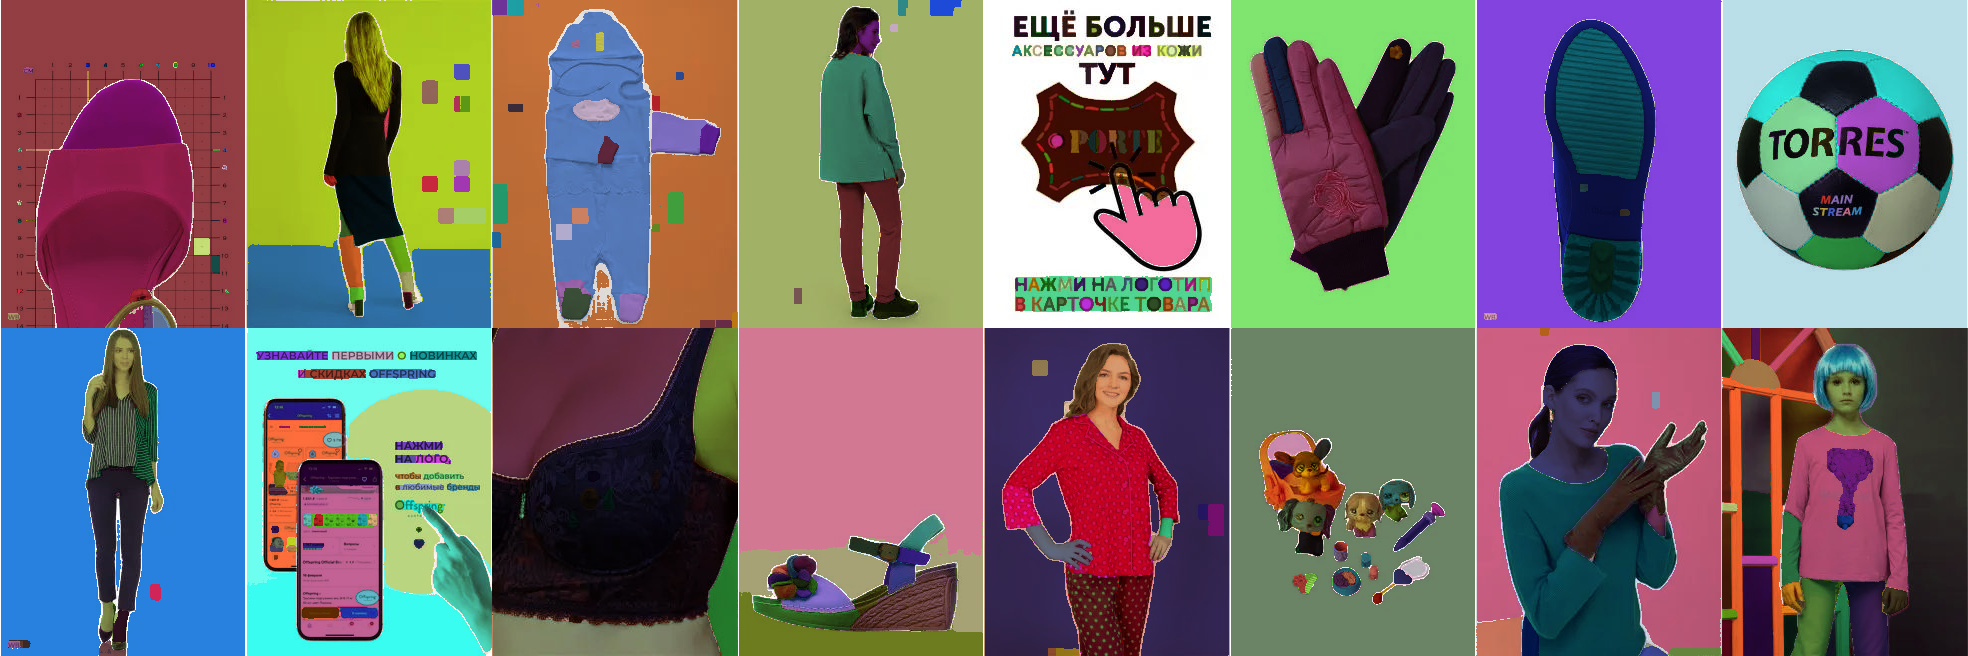

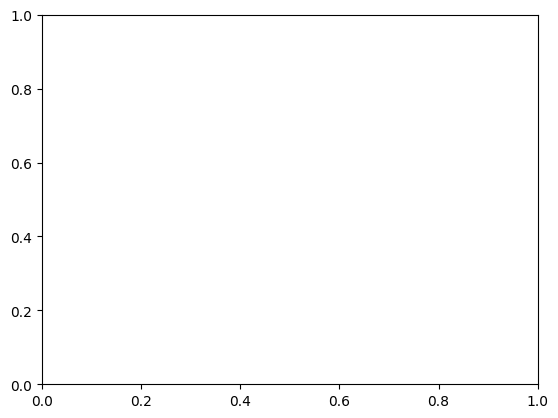

In [23]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        # img[m] = color_mask
        
        # img = np.array(img)
        # mask = (img[:,:,3] == 0).reshape((img.shape[0], img.shape[1], 1))
        # mask = np.concatenate((mask, mask, mask, mask), axis=2)
        # color = np.concatenate([[0, 0, 0], [255]]).reshape((1, 1, 4))
        # color = np.concatenate([color ]* img.shape[0], axis=0)
        # color = np.concatenate([color ]* img.shape[1], axis=1)
        # print(color.shape)
        # img[:, :, 3] = 1
        img[m] =  (img[m] * 0.15 + color_mask * 0.85)
    
        # color2 = np.concatenate([np.random.random(3) * 255, [1]]).reshape((1, 1, 4))
        # color2 = np.concatenate([color2 ]* img.shape[0], axis=0)
        # color2 = np.concatenate([color2 ]* img.shape[1], axis=1)
        # # print(color.shape)
        # img[~mask] = (base_image[~mask] * 0.65 + color2[~mask] * 0.35)
        img[:, :, 3] = 1
        # img = Image.fromarray(((img).astype('uint8')), mode='RGBA',)
        # images_without_background[ind] = img

    # ax.imshow(img)
    return ax, img

# plt.figure(figsize=(10,10))
# 
new_im = Image.new('RGBA', (246 * 8, 328* 2))

# im = Image.fromarray(images[1], 'RGB')
# 
# 
# # plt.figure(figsize=(20,20))
# # plt.imshow(images[1])
# ax, mask_img = show_anns(masks[1])
# plt.axis('off')
# plt.style.use('classic')
# # im.save(os.path.join(DATA_PATCH, 'res', f'r.jpg'))
# # plt.savefig(os.path.join(DATA_PATCH, 'res', f'r1.jpg'))
# im_m = Image.fromarray((mask_img * np.concatenate((images[1].copy(), np.ones_like(images[1])[:, :, 0:1] * 255), axis=2).astype(np.uint8)
#    ).astype('uint8'), 'RGBA',)
# # im_m.show()
# # im.show()
# # plt.imsave
# 
# # plt.show()      
# # show_anns(masks[1])

#Here I resize my opened image, so it is no bigger than 100,100

#Iterate through a 4 by 4 grid with 100 spacing, to place my image

for i in range(0, 8,1):
    for j in range(0, 2,1):
        #I change brightness of the images, just to emphasise they are unique copies.
        # im=Image.eval(im,lambda x: x+(i+j)/30)
        #paste the image at location i,j:
        # im = images_without_background[i * 2 + j]
        # im.thumbnail((246,328))
        # new_im.paste(im, (i*246,j * 328))
        
        mask = masks[i * 2 + j]
        ax, mask_img = show_anns(mask)
        # np.concatenate([mask, np.ones([len(mask), len(mask[0]), 1])], axis=2)
        im = Image.fromarray(images[i * 2 + j], 'RGB')

        im_m = Image.fromarray((mask_img * np.concatenate((images[i * 2 + j].copy(), np.ones_like(images[i * 2 + j])[:, :, 0:1] * 255), axis=2).astype(np.uint8)
   ).astype('uint8'), 'RGBA',)
        # im.paste(im_m, (0, 0))
        # im.alpha_composite(im_m)
        # im = 
        im_m.thumbnail((246,328))
        new_im.paste(im_m, (i*246,j * 328))
        

#Iterate through a 4 by 4 grid with 100 spacing, to place my image
# new_im = Image.new('RGBA', (246 * 4, 328* 4))
# for i in range(0, 4,1):
#     for j in range(0, 4,1):
#         #I change brightness of the images, just to emphasise they are unique copies.
#         # im=Image.eval(im,lambda x: x+(i+j)/30)
#         #paste the image at location i,j:
#         mask = masks[i * 4 + j]
#         ax, mask_img = show_anns(mask)
#         # np.concatenate([mask, np.ones([len(mask), len(mask[0]), 1])], axis=2)
#         im = Image.fromarray(images[i * 4 + j], 'RGB')
# 
#         im_m = Image.fromarray((mask_img * np.concatenate((images[i * 4 + j].copy(), np.ones_like(images[i * 4 + j])[:, :, 0:1] * 255), axis=2).astype(np.uint8)
#    ).astype('uint8'), 'RGBA',)
#         # im.paste(im_m, (0, 0))
#         # im.alpha_composite(im_m)
#         # im = 
#         im_m.thumbnail((246,328))
#         new_im.paste(im_m, (i*246,j * 328))

new_im.show()

# for image, mask in zip(images, masks):
#     plt.imshow(image)
#     show_anns(mask)
    
# plt.axis('off')
# plt.show() 

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [18]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [19]:
masks2 = mask_generator_2.generate(image)

In [20]:
len(masks2)

26

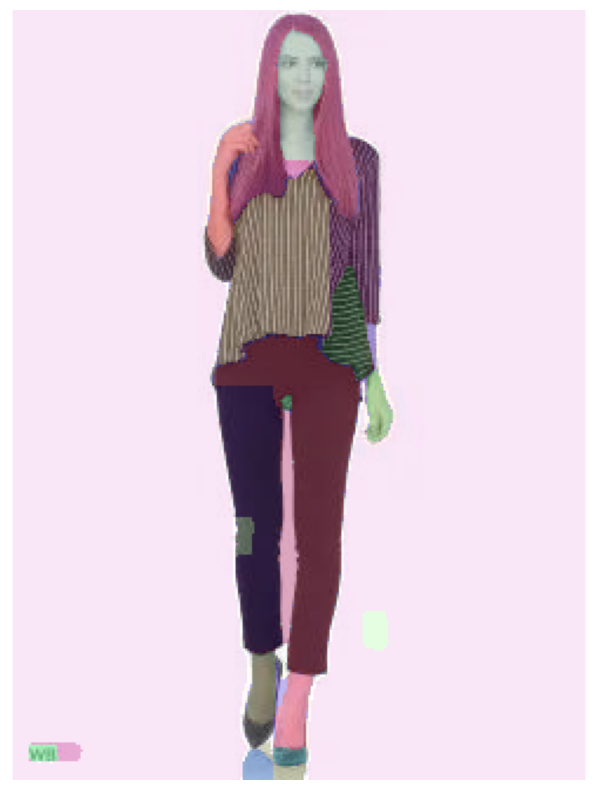

In [21]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show() 